In [1]:
import time
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
# for visualizing missing values
import missingno as msno
from pathlib import Path
import os
import dataframe_image as dfi
import joblib # for save xgboost model

from helper_functions import utils

# How enable_cagegorical works: https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
from xgboost import XGBRegressor
from IPython.display import display
import dataframe_image as dfi

# for display plot inline
%matplotlib inline
# change the style
matplotlib.style.use('ggplot')

# Load Data

In [2]:
# Load your dataset

dataset_f = '../data/dataset/2023_Residential_extra_preprocessed.csv'
metadata_f = '../data/dataset/2023_Residential_extra_preprocessed.json'

# This is for saving the prediciton results
output_dir = Path(f'./results/final_report/MLS/XGBoost_extra')
output_dir.mkdir(parents=True, exist_ok=True)

figure_name = "XGBoost<br>(no extra)"

remove_features = [
    # # estimation
    # # "Lp_dol", "Taxes",
    # # school
    # "s_2km_total", "s_2km_public", "s_2km_private", "s_2km_catholic", "s_2km_ele", "s_2km_sec", "s_2km_hi_ele_score", "s_2km_hi_sec_score", "s_2km_avg_ele_score", "s_2km_avg_sec_score",
    # # census
    # "labour_force_perc", "avg_household_income", "owned_perc", "with_children_perc", "households", "married__perc", "single__perc", "university_degree_perc", "median_age", "population", "age_0_9_perc", "age_10_19_perc", "age_20_34_perc", "age_35_64_perc",
    # # market
    # "average_sold_price", "average_listing_price", "median_sold_price", "median_listing_price", "average_days_on_market", "median_days_on_market", "dollar_volume", "new_listing_count", "sold_listing_count", "sold_overasking_count", "sold_underasking_count", "active_listing_count", "sales_to_new_listing_ratio", "months_of_inventory",
    # # transit
    # "ttc_subway_1km", "go_train_1km", "trainsit_1km",
]

dataset = pd.read_csv(dataset_f)
dataset.set_index('Ml_num', inplace = True)

with open(metadata_f, "r") as f:
    metadata = json.loads(f.read())


with open(os.path.join(output_dir, "remove_features.json"), "w") as f:
    f.write(json.dumps(remove_features))

# Handle datatype res

In [3]:
numerics_int = metadata["features"]["integer"]
numerics_float = metadata["features"]["float"]
numerics_bool = metadata["features"]["boolean"]
categories = metadata["features"]["category"]
    

for num in numerics_float:
    dataset[num] = dataset[num].fillna(0).astype(np.float)
    
for num in numerics_int:
    dataset[num] = dataset[num].fillna(0).round().astype('int64')
    
for num in numerics_bool:
    dataset[num] = dataset[num].astype('bool')

for category in categories:
    dataset[category] = dataset[category].astype("category")


features = []
for k,v in metadata["features"].items():
    features.extend(v)


features_set = set(features)
for feat in remove_features:
    if feat in features_set:
        features.remove(feat)

    
dataset = dataset[features]

C:\Users\Frank\AppData\Local\Temp\ipykernel_28104\1398800062.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset[num] = dataset[num].fillna(0).astype(np.float)


# Base Model XGBoost

In [4]:
def xgboost_model(data, train_verbose=0):
    
    start_time = time.time()
    
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor
    my_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=4, device="cuda", eval_metric="mae", early_stopping_rounds=20, enable_categorical=True)
    my_model.fit(data["train_x"], data["train_y"], eval_set=[(data["validate_x"], data["validate_y"])], verbose=train_verbose)#,feature_weights=feature_weights)

    print(f"Train time: {time.time()-start_time:.2f} seconds")
    
    
    mae_history = my_model.evals_result()
    mae_data = mae_history["validation_0"]["mae"]
    plt.plot(range(1, len(mae_data) + 1), mae_data)
    plt.annotate('%0.2f' % mae_data[-1], xy=(1, mae_data[-1]), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.savefig(os.path.join(output_dir, 'mae.png'))
    plt.show()
    
    
    
    return my_model
    
    
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    # for i in range(shap_values.values.shape[1]):
    #     importances.append(np.mean(np.abs(shap_values.values[:, i])))
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

# Residential

     all data: (50026, 74)
train data: (45024, 74)
validate data: (5002, 74)
Train time: 16.39 seconds


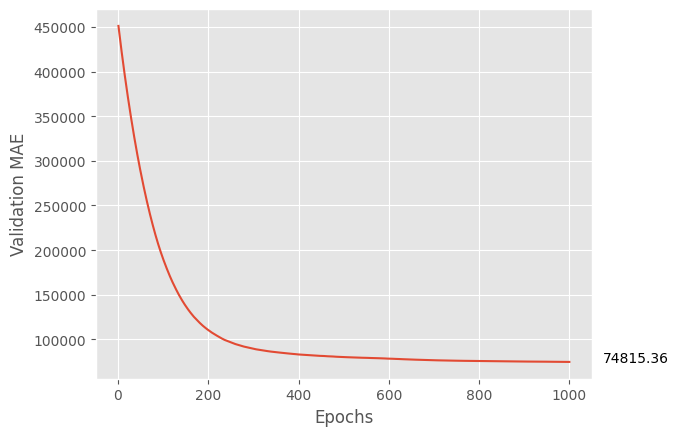

['results\\final_report\\MLS\\XGBoost_extra\\xgboost_model.joblib']

In [11]:
data_res = utils.split_data(dataset, 0.1)
model_res = xgboost_model(data_res, train_verbose=0)
model_pred = model_res.predict(data_res["validate_x"])

result_res = utils.predict_result(data_res["validate_x"], data_res["validate_y"], model_pred, os.path.join(output_dir, "res_validate_result.csv"))


pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
result_res.describe()

# df_styled = result_res.describe().style.background_gradient() #adding a gradient based on values in cell
dfi.export(result_res.describe(), os.path.join(output_dir, "describe.png"))


#### save model
# import joblib
#save model
joblib.dump(model_res, os.path.join(output_dir, "xgboost_model.joblib")) 

#load saved model
# xgb = joblib.load(filename)


In [6]:
style_worst = utils.display_worst_prediction(data_res["validate_x"], data_res["validate_y"], model_pred, name=figure_name)
display(style_worst)
dfi.export(style_worst, os.path.join(output_dir, 'top_worst_predictions.png'))

,Prediction,Sale Price,Different Percentage
Ml_num,,,
X7281176,"522,234","180,000",190.13%
S6719890,"194,103","80,000",142.63%
W7250588,"2,944,143","1,250,000",135.53%
S6205708,"211,775","90,500",134.01%
S7003572,"189,135","82,000",130.65%
S7034508,"1,054,856","475,000",122.07%
N7231740,"9,320,457","4,800,000",94.18%
C7048664,"636,184","350,000",81.77%
C6756384,"10,497,874","6,125,000",71.39%


In [7]:
style_pred_area = utils.display_predict_result(data_res["validate_x"], data_res["validate_y"], model_pred, name=figure_name, group_by="Area", sort_by="Homes", ascending=False)
display(style_pred_area)
dfi.export(style_pred_area, os.path.join(output_dir, 'predictions_by_area.png'))

,Median Error,Within 5% of Sales Price,Within 10% of Sales Price,Within 20% of Sales Price,Homes
Area,,,,,
All Areas,4.85%,51.11%,82.03%,97.68%,"10,005"
Toronto,6.64%,39.74%,70.75%,95.10%,"2,451"
York,5.41%,46.10%,80.15%,98.08%,"1,874"
Peel,4.00%,60.66%,90.14%,99.41%,"1,703"
Durham,5.65%,44.40%,81.68%,98.62%,"1,599"
Simcoe,3.28%,68.00%,90.92%,98.33%,"1,200"
Halton,4.09%,59.86%,88.32%,98.14%,"1,019"
Dufferin,3.40%,67.30%,87.42%,96.86%,159


In [8]:
style_pred_muni = utils.display_predict_result(data_res["validate_x"], data_res["validate_y"], model_pred, name=figure_name, group_by="Municipality_district", sort_by="Homes", ascending=False)
display(style_pred_muni)
dfi.export(style_pred_muni, os.path.join(output_dir, 'predictions_by_municipality.png'))

,Median Error,Within 5% of Sales Price,Within 10% of Sales Price,Within 20% of Sales Price,Homes
Municipality_district,,,,,
All Areas,4.85%,51.11%,82.03%,97.68%,"10,005"
Brampton,3.88%,62.93%,92.39%,99.78%,893
Mississauga,4.33%,55.96%,87.03%,99.40%,663
Oshawa,6.19%,40.22%,75.73%,97.75%,445
Markham,5.92%,41.35%,75.96%,97.53%,445
Vaughan,4.54%,53.65%,84.94%,98.35%,425
Oakville,4.76%,52.81%,85.96%,97.47%,356
Barrie,3.08%,74.41%,96.47%,99.41%,340
Whitby,5.60%,46.87%,84.78%,99.70%,335


In [9]:
# # https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# https://github.com/slundberg/shap/issues/2662
# https://discuss.xgboost.ai/t/xgboost-python-predict-vs-predict-pred-contribs-true/1596

import xgboost as xgb
from tqdm.notebook import tqdm as tqdm
import shap
from scipy.special import softmax

shap_values_res = model_res._Booster.predict(xgb.DMatrix(data_res["validate_x"], enable_categorical=True), pred_contribs=True)
# Also remove the last column because it contains the bias term.
shap_values_res = shap_values_res[:, :-1]

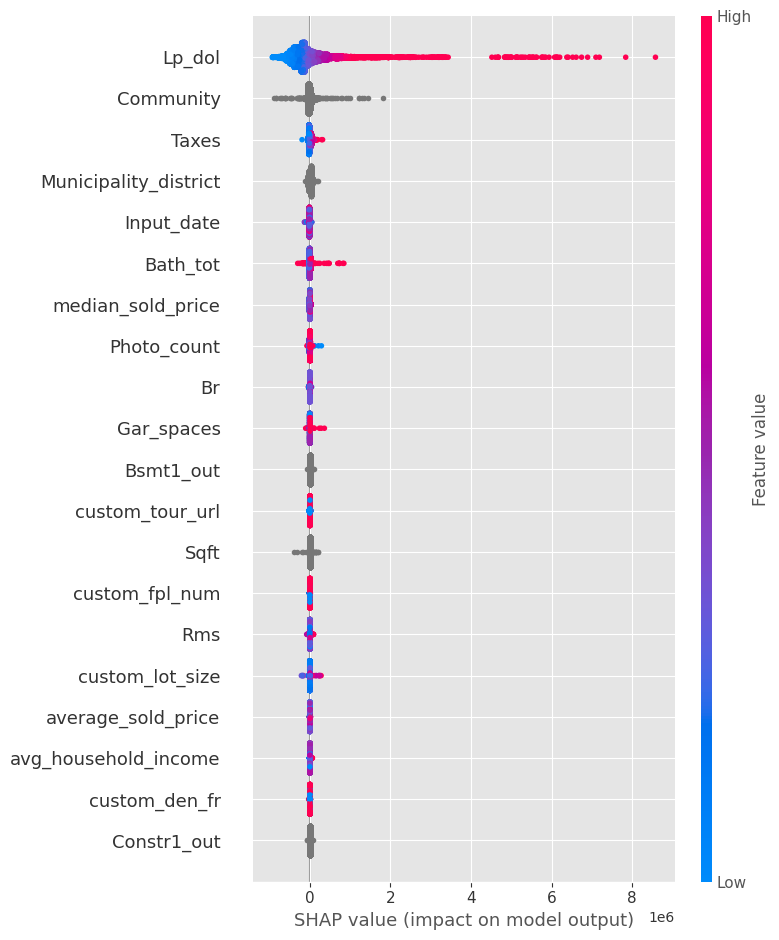

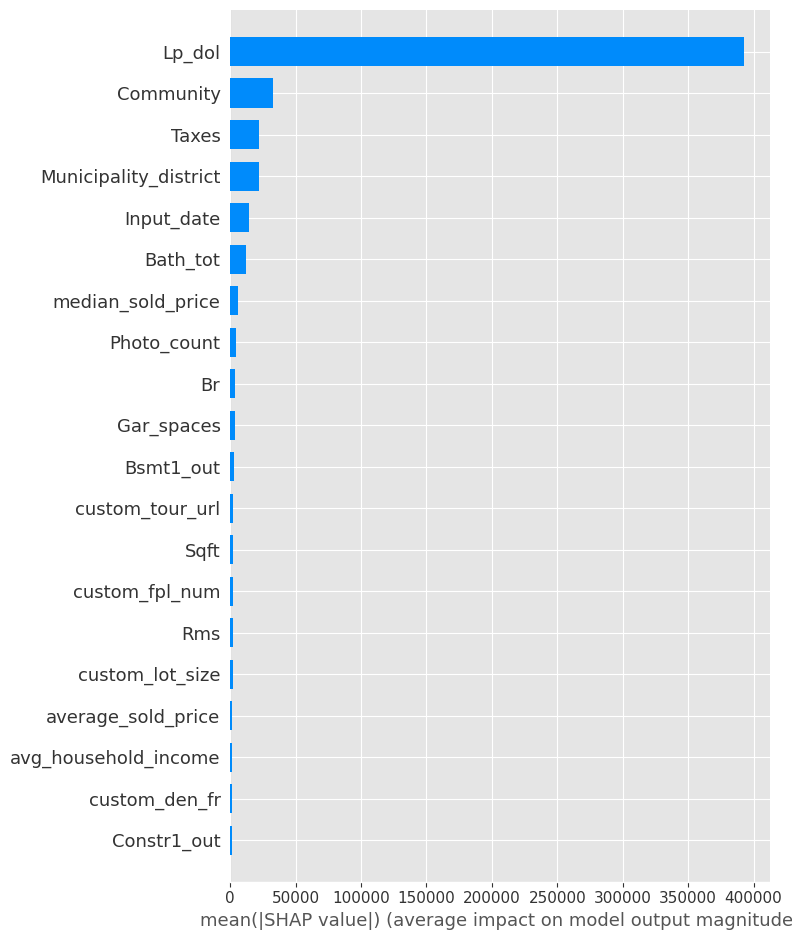

Lp_dol -> 392974.4688 (softmax = 1.0000)
Municipality_district -> 32594.1758 (softmax = 0.0000)
Lng -> 22066.9941 (softmax = 0.0000)
Area -> 21661.2012 (softmax = 0.0000)
Sp_dol -> 13979.6533 (softmax = 0.0000)
Bath_tot -> 11700.6006 (softmax = 0.0000)
average_listing_price -> 6175.3618 (softmax = 0.0000)
Photo_count -> 4785.4683 (softmax = 0.0000)
Br -> 3333.0012 (softmax = 0.0000)
Gar_spaces -> 3284.4143 (softmax = 0.0000)
Constr2_out -> 2587.6038 (softmax = 0.0000)
custom_den_fr -> 2431.0625 (softmax = 0.0000)
Acres -> 2263.8362 (softmax = 0.0000)
custom_tour_url -> 1918.2869 (softmax = 0.0000)
Rms -> 1829.7448 (softmax = 0.0000)
Taxes -> 1761.1127 (softmax = 0.0000)
age_35_64_perc -> 1594.6421 (softmax = 0.0000)
labour_force_perc -> 1367.2542 (softmax = 0.0000)
months_of_inventory -> 1267.3102 (softmax = 0.0000)
Comp_pts -> 1190.5487 (softmax = 0.0000)
Sqft -> 1176.9377 (softmax = 0.0000)
Bsmt1_out -> 1068.1575 (softmax = 0.0000)
Bsmt2_out -> 1052.3815 (softmax = 0.0000)
Constr1_ou

In [10]:
# For text features, both engineered and generated by word2vec, tests were conducted to show that they bring significant contribution to prediction results accuracy. All text features were retained in the final model.
# Grey is for NaN feature values (there are never NaN SHAP values), but I would be surprised if your whole dataset is NaN.

# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/#:~:text=Mean%20absolute%20SHAP%20values%20are,we're%20interested%20in).

fig = shap.summary_plot(shap_values_res, data_res["validate_x"], show=False)
plt.savefig(os.path.join(output_dir, 'shap.png'))
plt.show()
fig = shap.summary_plot(shap_values_res, data_res["validate_x"], plot_type='bar', show=False)
plt.savefig(os.path.join(output_dir, 'shap_bar.png'))
plt.show()
print_feature_importances_shap_values(shap_values_res, features)